## Utils

In [ ]:
!pip install h5py>=2.7.1 Keras>=2.1.5 scipy>=1.0.1 speechpy>=2.2 tensorflow>=1.7.0

In [ ]:
from google.colab import drive
import shutil
import os
import pickle
import sys
from typing import Tuple

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import scipy.io.wavfile as wav
from speechpy.feature import mfcc


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import Sequential
from keras.utils import np_utils
from keras.layers import LSTM as KERAS_LSTM, Dense, Dropout, Conv2D, Flatten, \
    BatchNormalization, Activation, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [ ]:
!git clone https://github.com/hkveeranki/speech-emotion-recognition.git

Cloning into 'speech-emotion-recognition'...
remote: Enumerating objects: 640, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 640 (delta 0), reused 0 (delta 0), pack-reused 635
Receiving objects: 100% (640/640), 31.47 MiB | 28.24 MiB/s, done.
Resolving deltas: 100% (114/114), done.


## Mount Drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## ENV Variables

In [ ]:
RAVDESS_PATH = "/content/gdrive/MyDrive/Major Project Sem 7 8/data/" #ravdess dataset path in the google drive
DATASET_DIR = '/content/speech-emotion-recognition/dataset/'  #path where dataset stored
_CLASS_LABELS = ("Neutral", "Angry", "Happy", "Sad") #class labels of the meotion directories
N_EPOCHS = 100 #number of epochs for training

In [ ]:
!mkdir /content/speech-emotion-recognition

mkdir: cannot create directory ‘/content/speech-emotion-recognition’: File exists


In [ ]:
!ls gdrive/MyDrive/'Major Project Sem 7 8'/data

Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


## Preparing Dataset

In [ ]:
!mkdir /content/speech-emotion-recognition/dataset
!mkdir /content/speech-emotion-recognition/dataset/Neutral
!mkdir /content/speech-emotion-recognition/dataset/Happy
!mkdir /content/speech-emotion-recognition/dataset/Angry
!mkdir /content/speech-emotion-recognition/dataset/Sad

mkdir: cannot create directory ‘/content/speech-emotion-recognition/dataset’: File exists
mkdir: cannot create directory ‘/content/speech-emotion-recognition/dataset/Neutral’: File exists
mkdir: cannot create directory ‘/content/speech-emotion-recognition/dataset/Happy’: File exists
mkdir: cannot create directory ‘/content/speech-emotion-recognition/dataset/Angry’: File exists
mkdir: cannot create directory ‘/content/speech-emotion-recognition/dataset/Sad’: File exists


In [ ]:
ravdess_directory_list = os.listdir(RAVDESS_PATH)
file_emotion = []
file_path = []
emotion_list = {'01': 'Neutral', '02' : 'Calm', '03' : 'Happy', '04' : 'Sad', '05' : 'Angry', '06' : 'Fearful', '07' : 'Disgust', '08' : 'Surprised'}
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(RAVDESS_PATH + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        if(part[2] in ['02','06','07','08']): continue #Calm, Fearful, Disgust  and Surprise emotions are dropped
        # third part in each file represents the emotion associated to that file.
        file_emotion = emotion_list.get(part[2])
        src = os.path.join(RAVDESS_PATH,dir,file)
        # print(src)
        shutil.copy(src, '{}{}'.format(DATASET_DIR,file_emotion))
        # file_path.append(Ravdess + dir + '/' + file)

In [ ]:
!cp -R /content/speech-emotion-recognition/dataset /content/gdrive/MyDrive/Major\ Project\ Sem\ 7\ 8

In [ ]:
%cd /content/speech-emotion-recognition/

/content/speech-emotion-recognition


### Defining Model Class and functions related to Model

All the functions with respect to using a model are all defined in a sngle abstract class which can be used according to use-case for reusability and modularity.

The functions include


*   train
*   predict
*   save model
*   evaluate model (give accuracy and other metrics)
*   load saved model



In [ ]:
class Model(object):
    """
    Model is the abstract class which determines how a model should be.
    Any model inheriting this class should do the following.

    1.  Set the model instance variable to the corresponding model class which
        which will provide methods `fit` and `predict`.

    2.  Should implement the following abstract methods `load_model`,
        `save_model` `train` and `evaluate`. These methods provide the
        functionality to save the model to the disk, load the model from the
        disk and train the model and evaluate the model to return appropriate
        measure like accuracy, f1 score, etc.

    Attributes:
        model (Any): instance variable that holds the model.
        save_path (str): path to save the model.
        name (str): name of the model.
        trained (bool): True if model has been trained, false otherwise.
    """

    def __init__(self, save_path: str = '', name: str = 'Not Specified'):
        """
        Default constructor for abstract class Model.

        Args:
            save_path(str): path to save the model to.
            name(str): name of the model given as string.

        """
        # Place holder for model
        self.model = None
        # Place holder on where to save the model
        self.save_path = save_path
        # Place holder for name of the model
        self.name = name
        # Model has been trained or not
        self.trained = False

    def train(self, x_train: np.ndarray, y_train: np.ndarray,
              x_val: np.ndarray = None,
              y_val: np.ndarray = None) -> None:
        """
        Trains the model with the given training data.

        Args:
            x_train (numpy.ndarray): samples of training data.
            y_train (numpy.ndarray): labels for training data.
            x_val (numpy.ndarray): Optional, samples in the validation data.
            y_val (numpy.ndarray): Optional, labels of the validation data.

        """
        # This will be specific to model so should be implemented by
        # child classes
        raise NotImplementedError()

    def predict(self, samples: np.ndarray) -> Tuple:
        """
        Predict labels for given data.

        Args:
            samples (numpy.ndarray): data for which labels need to be predicted

        Returns:
            list: list of labels predicted for the data.

        """
        results = []
        for _, sample in enumerate(samples):
            results.append(self.predict_one(sample))
        return tuple(results)

    def predict_one(self, sample) -> int:
        """
        Predict label of a single sample. The reason this method exists is
        because often we might want to predict label for a single sample.

        Args:
            sample (numpy.ndarray): Feature vector of the sample that we want to
                                    predict the label for.

        Returns:
            int: returns the label for the sample.
        """
        raise NotImplementedError()

    def restore_model(self, load_path: str = None) -> None:
        """
        Restore the weights from a saved model and load them to the model.

        Args:
            load_path (str): Optional, path to load the weights from a given path.

        """
        to_load = load_path or self.save_path
        if to_load is None:
            sys.stderr.write(
                "Provide a path to load from or save_path of the model\n")
            sys.exit(-1)
        self.load_model(to_load)
        self.trained = True

    def load_model(self, to_load: str) -> None:
        """
        Load the weights from the given saved model.

        Args:
            to_load: path containing the saved model.

        """
        raise NotImplementedError()

    def save_model(self) -> None:
        """
        Save the model to path denoted by `save_path` instance variable.
        """
        # This will be specific to model so should be implemented by
        # child classes
        raise NotImplementedError()

    def evaluate(self, x_test: np.ndarray, y_test: np.ndarray) -> None:
        """
        Evaluate the current model on the given test data.

        Predict the labels for test data using the model and print the relevant
        metrics like accuracy and the confusion matrix.

        Args:
            x_test (numpy.ndarray): Numpy nD array or a list like object
                                    containing the samples.
            y_test (numpy.ndarray): Numpy 1D array or list like object
                                    containing the labels for test samples.
        """
        predictions = self.predict(x_test)
        print(y_test)
        print(predictions)
        print('Accuracy:%.3f\n' % accuracy_score(y_pred=predictions,
                                                 y_true=y_test))
        print('Confusion matrix:', confusion_matrix(y_pred=predictions,
                                                    y_true=y_test))


### Extracting features from audio

Extracting the following features using the defined functions.

*   Mel Frequency Cepstral Coefficients (MFCC) - 39 coefficients are taken as mentioned in papers referred.

In [ ]:

def extract_data(flatten):
    data, labels = get_data(DATASET_DIR, class_labels=_CLASS_LABELS,
                            flatten=flatten)
    x_train, x_test, y_train, y_test = train_test_split(
        data,
        labels,
        test_size=0.2,
        random_state=42)
    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(
        y_test), len(_CLASS_LABELS)


def get_feature_vector(file_path, flatten):
    return get_feature_vector_from_mfcc(file_path, flatten, mfcc_len=39)

In [ ]:
mean_signal_length = 32000


def get_feature_vector_from_mfcc(file_path: str, flatten: bool,
                                 mfcc_len: int = 39) -> np.ndarray:
    """
    Make feature vector from MFCC for the given wav file.

    Args:
        file_path (str): path to the .wav file that needs to be read.
        flatten (bool) : Boolean indicating whether to flatten mfcc obtained.
        mfcc_len (int): Number of cepestral co efficients to be consider.

    Returns:
        numpy.ndarray: feature vector of the wav file made from mfcc.
    """
    fs, signal = wav.read(file_path)
    s_len = len(signal)

    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem),
                        'constant', constant_values=0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    mel_coefficients = mfcc(signal, fs, num_cepstral=mfcc_len)
    if flatten:

        mel_coefficients = np.ravel(mel_coefficients)
    return mel_coefficients


def get_data(data_path: str, flatten: bool = True, mfcc_len: int = 39,
             class_labels: Tuple = ("Neutral", "Angry", "Happy", "Sad")) -> \
        Tuple[np.ndarray, np.ndarray]:
    """Extract data for training and testing.

    1. Iterate through all the folders.
    2. Read the audio files in each folder.
    3. Extract Mel frequency cepestral coefficients for each file.
    4. Generate feature vector for the audio files as required.

    Args:
        data_path (str): path to the data set folder
        flatten (bool): Boolean specifying whether to flatten the data or not.
        mfcc_len (int): Number of mfcc features to take for each frame.
        class_labels (tuple): class labels that we care about.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Two numpy arrays, one with mfcc and
        other with labels.


    """
    data = []
    labels = []
    names = []
    cur_dir = os.getcwd()
    sys.stderr.write('curdir: %s\n' % cur_dir)
    os.chdir(data_path)
    for i, directory in enumerate(class_labels):
        sys.stderr.write("started reading folder %s\n" % directory)
        os.chdir(directory)
        for filename in os.listdir('.'):
            filepath = os.getcwd() + '/' + filename
            feature_vector = get_feature_vector_from_mfcc(file_path=filepath,
                                                          mfcc_len=mfcc_len,
                                                          flatten=flatten)
            data.append(feature_vector)
            labels.append(i)
            names.append(filename)
        sys.stderr.write("ended reading folder %s\n" % directory)
        os.chdir('..')
    os.chdir(cur_dir)
    return np.array(data), np.array(labels)

### Defining Architecture of NNs

The models defined below are


*   DNN abstract class to define common functionality between CNN and LSTM
*   CNN
>  
    1. Convolutional Layer 1
    2. Batch Normalization Layer 1
    3. Convolutional Layer 2
    4. Batch Normalization Layer 2
    5. Max Pooling Layer 1
    6. Convolutional Layer 3
    7. Batch Normalization Layer 3
    8. Convolutional Layer 4
    9. Batch Normalization Layer 4
    10. Max Pooling layer 2
    11. Dense Layer
    12. Batch Normalization Layer 5
    
    Activation used - ReLU

    Dropout - 0.2 in last layer to prevent overfitting










In [ ]:

class DNN(Model):
    """
    This class is parent class for all Deep neural network models. Any class
    inheriting this class should implement `make_default_model` method which
    creates a model with a set of hyper parameters.
    """

    def __init__(self, input_shape, num_classes, **params):
        """
        Constructor to initialize the deep neural network model. Takes the input
        shape and number of classes and other parameters required for the
        abstract class `Model` as parameters.

        Args:
            input_shape (tuple): shape of the input
            num_classes (int): number of different classes ( labels ) in the data.
            **params: Additional parameters required by the underlying abstract
                class `Model`.

        """
        super(DNN, self).__init__(**params)
        self.input_shape = input_shape
        self.model = Sequential()
        self.make_default_model()
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam',
                           metrics=['accuracy'])
        print(self.model.summary(), file=sys.stderr)
        self.save_path = self.save_path or self.name + '_best_model.h5'

    def load_model(self, to_load):
        """
        Load the model weights from the given path.

        Args:
            to_load (str): path to the saved model file in h5 format.

        """
        try:
            self.model.load_weights(to_load)
            self.trained = True
        except:
            sys.stderr.write("Invalid saved file provided")
            sys.exit(-1)

    def save_model(self):
        """
        Save the model weights to `save_path` provided while creating the model.
        """
        self.model.save_weights(self.save_path)

    def train(self, x_train, y_train, x_val=None, y_val=None, n_epochs=50):
        """
        Train the model on the given training data.


        Args:
            x_train (numpy.ndarray): samples of training data.
            y_train (numpy.ndarray): labels for training data.
            x_val (numpy.ndarray): Optional, samples in the validation data.
            y_val (numpy.ndarray): Optional, labels of the validation data.
            n_epochs (int): Number of epochs to be trained.

        """
        best_acc = 0
        loss = []
        acc = []
        history = {'accuracy':[],'loss':[]}
        if x_val is None or y_val is None:
            x_val, y_val = x_train, y_train
        for i in range(n_epochs):
            # Shuffle the data for each epoch in unison inspired
            # from https://stackoverflow.com/a/4602224
            print("Epoch ",i+1,"\n")
            p = np.random.permutation(len(x_train))
            x_train = x_train[p]
            y_train = y_train[p]
            history_temp = self.model.fit(x_train, y_train, batch_size=32, epochs=1)
            history['accuracy'].append(history_temp.history['accuracy'])
            history['loss'].append(history_temp.history['loss'])
            loss_temp, acc_temp = self.model.evaluate(x_val, y_val)
            loss.append(loss_temp)
            acc.append(acc_temp)
            if acc_temp > best_acc:
                best_acc = acc_temp
        self.trained = True
        return history,loss,acc

    def predict_one(self, sample):
        if not self.trained:
            sys.stderr.write(
                "Model should be trained or loaded before doing predict\n")
            sys.exit(-1)
        return np.argmax(self.model.predict(np.array([sample])))

    def make_default_model(self) -> None:
        """
        Make the model with default hyper parameters
        """
        # This has to be implemented by child classes. The reason is that the
        # hyper parameters depends on the model.
        raise NotImplementedError()

class CNN(DNN):
    """
    This class handles CNN for speech emotion recognitions
    """

    def __init__(self, **params):
        params['name'] = 'CNN'
        super(CNN, self).__init__(**params)

    def make_default_model(self):
        """
        Makes a CNN keras model with the default hyper parameters.
        """
        self.model.add(Conv2D(8, (13, 13),
                              input_shape=(
                                  self.input_shape[0], self.input_shape[1], 1)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(8, (13, 13)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 1)))
        self.model.add(Conv2D(8, (13, 13)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(8, (2, 2)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 1)))
        self.model.add(Flatten())
        self.model.add(Dense(64))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.2))
class LSTM(DNN):
    """
    This class handles CNN for speech emotion recognitions
    """

    def __init__(self, **params):
        params['name'] = 'LSTM'
        super(LSTM, self).__init__(**params)

    def make_default_model(self):
        """
        Makes the LSTM model with keras with the default hyper parameters.
        """
        self.model.add(
            KERAS_LSTM(128,
                       input_shape=(self.input_shape[0], self.input_shape[1])))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(16, activation='tanh'))



In [ ]:
def plot_metric(model,history,loss,acc,x_test,y_test):
  # print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

  epochs = [i for i in range(N_EPOCHS)]
  fig , ax = plt.subplots(1,2)
  train_acc = history['accuracy']
  train_loss = history['loss']
  test_acc = acc
  test_loss = loss

  fig.set_size_inches(20,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
  ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

## Train and Predict

In [ ]:
!rmdir /content/speech-emotion-recognition/dataset/Sad/.ipynb_checkpoints

rmdir: failed to remove '/content/speech-emotion-recognition/dataset/Sad/.ipynb_checkpoints': No such file or directory


In [ ]:
%cd /content/speech-emotion-recognition

/content/speech-emotion-recognition


### CNN Model


curdir: /content/speech-emotion-recognition
started reading folder Neutral
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
ended reading folder Neutral
started reading folder Angry
ended reading folder Angry
started reading folder Happy
ended reading folder Happy
started reading folder Sad
ended reading folder Sad


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 186, 27, 8)        1360      
                                                                 
 batch_normalization_100 (Ba  (None, 186, 27, 8)       32        
 tchNormalization)                                               
                                                                 
 activation_100 (Activation)  (None, 186, 27, 8)       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 174, 15, 8)        10824     
                                                                 
 batch_normalization_101 (Ba  (None, 174, 15, 8)       32        
 tchNormalization)                                               
                                                                 
 activation_101 (Activation)  (None, 174, 15, 8)     

None


7/7 [==============================] - 1s 112ms/step - loss: 0.6090 - accuracy: 0.3300
Epoch  2 

7/7 [==============================] - 1s 110ms/step - loss: 0.5436 - accuracy: 0.4729
Epoch  3 

7/7 [==============================] - 1s 112ms/step - loss: 0.5233 - accuracy: 0.4778
Epoch  4 

7/7 [==============================] - 1s 113ms/step - loss: 0.4644 - accuracy: 0.5468
Epoch  5 

7/7 [==============================] - 1s 112ms/step - loss: 0.4394 - accuracy: 0.6010
Epoch  6 

7/7 [==============================] - 1s 114ms/step - loss: 0.4392 - accuracy: 0.5714
Epoch  7 

7/7 [==============================] - 1s 114ms/step - loss: 0.4131 - accuracy: 0.6355
Epoch  8 

7/7 [==============================] - 1s 111ms/step - loss: 0.4209 - accuracy: 0.5862
Epoch  9 

7/7 [==============================] - 1s 111ms/step - loss: 0.3938 - accuracy: 0.6502
Epoch  10 

7/7 [==============================] - 1s 111ms/step - loss: 0.3956 - accuracy: 0.5961
Epoch  11 

7/7 [=============

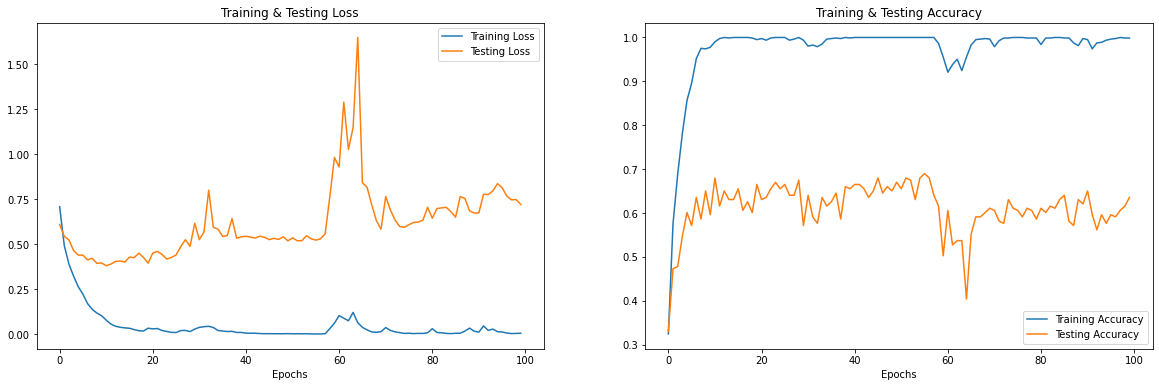

INFO:tensorflow:Assets written to: ram://6896abaa-18ee-4fc5-a442-72bb856a2c47/assets


In [ ]:

def cnn_example():
    to_flatten = False
    x_train, x_test, y_train, y_test, num_labels = extract_data(flatten=to_flatten)
    y_train = np_utils.to_categorical(y_train)
    y_test_train = np_utils.to_categorical(y_test)
    in_shape = x_train[0].shape
    x_train = x_train.reshape(x_train.shape[0], in_shape[0], in_shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], in_shape[0], in_shape[1], 1)
    model = CNN(input_shape=x_train[0].shape,
                num_classes=num_labels)
    history,loss,accuracy = model.train(x_train, y_train, x_test, y_test_train,n_epochs =N_EPOCHS)
    model.evaluate(x_test, y_test)

    #predicting for one file
    filename = '/content/Ses01F_impro01_F000.wav'
    print("*"*10)
    print('prediction', model.predict_one(
        get_feature_vector_from_mfcc(filename, flatten=to_flatten)),
          'Actual 3')
    print("*"*10)

    plot_metric(model,history,loss,accuracy,x_test,y_test)
    # print('CNN Done')
    if not os.path.isdir("result"):
        os.mkdir("result")

    pickle.dump(model, open("result/cnn_ravdess.model", "wb")) #saving the model


if __name__ == "__main__":
    cnn_example()


### USING THE dnn LOAD_MODEL FUNCTION

In [ ]:
to_flatten = False
x_train, x_test, y_train, y_test, num_labels = extract_data(flatten=to_flatten)
y_train = np_utils.to_categorical(y_train)
y_test_train = np_utils.to_categorical(y_test)
in_shape = x_train[0].shape
x_train = x_train.reshape(x_train.shape[0], in_shape[0], in_shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], in_shape[0], in_shape[1], 1)
model = CNN(input_shape=x_train[0].shape,num_classes=num_labels)
model.load_model(to_load='/content/speech-emotion-recognition/models/best_model_CNN.h5')
model.evaluate(x_test, y_test)
filename = '/content/speech-emotion-recognition/dataset/Sad/03a05Tc.wav'
print("*"*10)
print('prediction', model.predict_one(get_feature_vector_from_mfcc(filename, flatten=to_flatten)),'Actual 3')
print("*"*10)

### LSTM Model

curdir: /content/speech-emotion-recognition
started reading folder Neutral
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
ended reading folder Neutral
started reading folder Angry
ended reading folder Angry
started reading folder Happy
ended reading folder Happy
started reading folder Sad
ended reading folder Sad


Starting LSTM
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               86016     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 32)                4128      
                                                                 
 dense_43 (Dense)            (None, 16)                528       
                                                                 
 dense_44 (Dense)            (None, 4)                 68        
                                                                 
Total params: 90,740
Trainable params: 90,740
Non-trainable params: 0
_________________________________________________________________
Epoch  1 



None


7/7 [==============================] - 1s 47ms/step - loss: 0.5341 - accuracy: 0.3842
Epoch  2 

7/7 [==============================] - 0s 49ms/step - loss: 0.5110 - accuracy: 0.4778
Epoch  3 

7/7 [==============================] - 0s 51ms/step - loss: 0.4815 - accuracy: 0.5271
Epoch  4 

7/7 [==============================] - 0s 50ms/step - loss: 0.4558 - accuracy: 0.5419
Epoch  5 

7/7 [==============================] - 0s 50ms/step - loss: 0.4303 - accuracy: 0.6059
Epoch  6 

7/7 [==============================] - 0s 50ms/step - loss: 0.4024 - accuracy: 0.6355
Epoch  7 

7/7 [==============================] - 0s 49ms/step - loss: 0.4005 - accuracy: 0.6355
Epoch  8 

7/7 [==============================] - 0s 49ms/step - loss: 0.4142 - accuracy: 0.5961
Epoch  9 

7/7 [==============================] - 0s 55ms/step - loss: 0.3529 - accuracy: 0.7143
Epoch  10 

7/7 [==============================] - 0s 52ms/step - loss: 0.3510 - accuracy: 0.6946
Epoch  11 

7/7 [=======================

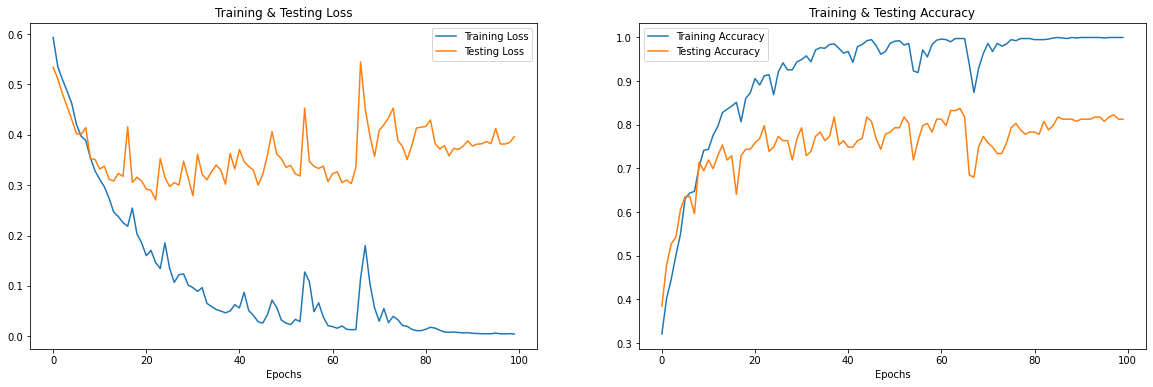

INFO:tensorflow:Assets written to: ram://b7c48181-d97a-4b4d-80e1-56531222edd2/assets


INFO:tensorflow:Assets written to: ram://b7c48181-d97a-4b4d-80e1-56531222edd2/assets


In [ ]:
def lstm_example():
    to_flatten = False
    x_train, x_test, y_train, y_test, num_labels = extract_data(
        flatten=to_flatten)
    y_train = np_utils.to_categorical(y_train)
    y_test_train = np_utils.to_categorical(y_test)
    print('Starting LSTM')
    model = LSTM(input_shape=x_train[0].shape,
                 num_classes=num_labels)
    history,loss,accuracy = model.train(x_train, y_train, x_test, y_test_train, n_epochs=N_EPOCHS)
    model.evaluate(x_test, y_test)

    #predicting for one file
    filename = '{}/Sad/03-01-04-01-01-02-01.wav'.format(DATASET_DIR)
    print("*"*10)
    print('prediction', model.predict_one(
        get_feature_vector_from_mfcc(filename, flatten=to_flatten)),
          'Actual 3')
    print("*"*10)
    plot_metric(model,history,loss,accuracy,x_test,y_test)
    # now we save the model
    # make result directory if doesn't exist yet
    if not os.path.isdir("result"):
        os.mkdir("result")

    pickle.dump(model, open("result/lstm_ravdess.model", "wb")) #saving the model

if __name__ == '__main__':
    lstm_example()

## Save Model to Google Drive

In [ ]:
!cp -r result /content/gdrive/MyDrive/'Major Project Sem 7 8'/ser2/$(date +%Y%m%d_%H%M%S)